In [ ]:
!pip install simpy
!pip install bintrees
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 14.8 MB/s 
  Created wheel for bintrees: filename=bintrees-2.2.0-cp38-cp38-linux_x86_64.whl size=199188 sha256=a25dd6f35ddfe142b7eddae6d0b3b94f65c39cdffab2ee7dc42b5aa2c94ccb36
  Stored in directory: /root/.cache/pip/wheels/68/4d/52/4744b42df3b9dee566b11f229c207bc2075d6d66d91d9fea7d
Successfully built bintrees


In [ ]:
from bintrees import rbtree
import pandas as pd
import simpy
import numpy as np
import numpy.random as random
import math

**CFS and FIFO define**


In [ ]:
MAXSIMTIME = 50000    # max simalation time
VERBOSE = False       # print extra log 
LAMBDA = 4            # Average arrival rate
MU = 8.0              # Average service rate per server
POPULATION = 50000000 
SERVICE_DISCIPLINE = 'FIFO'
LOGGED = True         # Write Log to files
COMPARE_ALONG = True  # Compare FIFO and CFS under multiple Lambda value
COMPARE_ONE = True    # Compare FIFO and CFS under 1 Lambda value and print its metrics
PLOTTED = True        # Draw plots
ALLOW_CONTEXTSWITCH = False # allow context switch in CFS
TARGET_LATENCY = 0.02       # minimum amount of time required for every runnable job to get at least one turn on the server
MIN_GRANULARITY = 0.004     # minumun amount of time a job has to run on server
DATA_PATH = './'  #data path for log files

# Giới thiệu về Completely Fair Scheduling

Completely Fair Scheduling là một giải thuật scheduling được sử dụng bởi hệ điều hành Linux kernel bản 2.6.23, với mục đích đảm bảo sự công bằng cho các task (job) được phục vụ, duy trì sự "công bằng" về thời gian mà server phục vụ cho các job.

## Đặc trưng của Completely Fair Scheduler

- CFS là một giải thuật scheduling dạng preemtive
- Mỗi một job sẽ được phân bổ một lượng thời gian là 1/N, với N là số Job hiện tại trong queue. Thời gian này được xác định mỗi khi job được server lấy từ queue để phục vụ
- Để đảm bảo công bằng, CFS có hai khái niệm:
  - target_latency: khoảng thời gian nhỏ nhất để đảm bảo **tất cả** các task trong Queue đều được phục vụ 1 lần bởi server. Mặc định của hệ điều hành Linux là 20ms, có nghĩa là nếu có N job, thì mỗi job sẽ được chạy trong khoảng thời gian 20/N ms
  - mininum_granularity: thời gian nhỏ nhất mà **mỗi** job phải thực thi trước khi bị preemted. Mặc định của hệ điều hành Linux là 4ms. 
- Giả sử target_latency là 20ms và minimun_granularity là 4ms, và hiện tại trong queue có 10 job, thì thay vì mỗi job sẽ chạy 20/10 = 2ms, các job buộc phải chạy ít nhất 4ms trước khi bị preempt bởi hệ thống. Lý do sử dụng minimun_granularity là do trong hệ điều hành, mỗi khi preemtive xảy ra, hệ điều hành phải tốn một khoảng thời gian để thực hiện context-switch (overhead). Nếu thời gian thực thi của job quá nhỏ, số lượng context-switch trở nên nhiều sẽ tạo nhiều overhead hơn và giảm hiệu suất hệ thống.
- CFS sắp xếp các job của Queue trong một Red-Black tree (RBtree), dựa trên key là virtual runtime (vruntime) - tức thời gian mà job đó được server phục vụ. Khi một job được server phục vụ, vruntime của nó sẽ được cập nhật theo công thức:
  > vruntime += thời gian được server phục vụ
- Server sẽ ưu tiên lấy các job có vruntime nhỏ nhất trong RBtree (các job ở ngoài cùng bên trái) để phục vụ trước. 

## Hoạt động của CFS scheduling

Trong mô phỏng M/M/1 với cách scheduling CFS, hoạt động của Server và Queue sẽ như sau:

1. Khi server chọn job, nó sẽ chọn job có thời gian vruntime bé nhất
2. Server tính timeslot cho job đó dựa trên target_latency và minimun_granularity và số lượng Job đang có trong queue.
3. Server sẽ chạy job theo **từng timeslot** đồng thời cập nhật vruntime của job đang chạy, cho tới khi một trong các sự kiện sau xảy ra:
  1. Job đang chạy hoàn thành
  2. Có một job vừa mới vào RBtree, lúc này vruntime của job vừa vào là nhỏ nhất (0)
  3. Có ít nhất 1 job trong RBtree có vruntime **nhỏ hơn** vruntime của job đang chạy
Nếu sự kiện thứ 2 và 3 xảy ra khi job đang chạy trong timeslot, server sẽ tiếp tục phục vụ job cho hết timeslot hiện tại trước khi preempt job.
4. Server sẽ preempt job đang chạy: 
  1. Cập nhật vruntime cho job đang chạy, trả lại về RBtree
  2. Làm context-switching (bỏ qua trong mô phỏng này)
  3. Lấy job có vruntime nhỏ nhất trong RBtree để thực thi tiếp

### Một số ghi chú về hiện thực của giải thuật:
- Theo lý thuyết, CFS sẽ sắp xếp các job trong RBtree với key là vruntime của các Job. Tuy nhiên, thực tế key sẽ được tính toán bằng một công thức khác,với hệ điều hành Linux là bao gồm các yếu tố về độ ưu tiên hoặc task I/O, kết hợp với vruntime để sắp xếp các Job hợp lý trong RBtree.
- Một số hiện thực của RBtree không cho phép có các key giống nhau, nên ta phải sử dụng công thức tính toán để tạo ra các key phù hợp, tránh trường hợp trùng Key gây mất Job





### Class `CFSJob`
Class định nghĩa một job, gồm các thuộc tính như sau:
- `name`: Tên job
- `arrtime`: Thời gian Job tới
- `duration`: Độ dài của job
- `vruntime`: Thời gian job được phục vụ bởi server

In [ ]:
class CFSJob:
    def __init__(self, name, arrtime, duration, vruntime):
        self.name = name
        self.arrtime = arrtime
        self.duration = duration
        self.vruntime = vruntime

    def __str__(self):
        return '%s at %d, length %d' % (self.name, self.arrtime, self.duration)

### Class `CFSSever`

Class định nghĩa server và cách server hoạt động. Class có một số hàm quan trọng như sau:

#### Hàm `serve`

Hàm chính quy định cách server phục vụ job. Tóm tắt về cách hoạt động như sau:
1. Nếu không có job trong hàng đợi, server sẽ ngủ
2. Nếu có job đang trong hàng đợi
	1. Tính toán timeslot cho Job chuẩn bị lấy ra. Nếu time slot < `min_granuality`, ép timeslot = `min_granuality`
	2. Lấy job từ hàng đợi
	3. Tính toán thời gian còn lại mà job cần chạy để hoàn thành
		>  `remaining_duration = j.duration - j.vruntime`
	4. Nếu trong hàng đợi đang có job:
		1. Tính toán khoảng cách giữa vruntime của job hiện tại và job có vruntime nhỏ nhất trong RBtree, nhằm mục đích xác định thời gian chạy của job hiện tại cho tới khi nó lớn hơn vruntime của job nhỏ nhất trong RBtree.
		> `diff_vruntime = self.Jobs.min_item()[1].vruntime - j.vruntime`
		2. Nếu `diff_vruntime < remaining_duration`, thực hiện tính thời gian chạy của job `temp_vruntime` bằng một số nguyên lần của timeslot sao cho >= `diff_vruntime`. Nếu thời gian tính được lớn hơn `remaining_duration`, ép thời gian này về lại `remaining_duration`
		3. Nếu `diff_vruntime >= remaining_duration`, cho thời gian chạy của job `temp_vruntime` là `remaining_duration`
	5. Nếu hàng chờ không có job nào, cho job hiện tại chạy tới hết `temp_vruntime = remaining_duration`
	6. Chạy job trong process `running_job` với khoảng thời gian `temp_vruntime`. Process này có thể bị interrupt khi có job mới vừa vào hệ thống.
	7. Xác định thời gian job thật sự chạy `actual_vruntime` (trong trường hợp job bị interrupt khi có job mới vào, nó có thể chạy ít hơn so với dự tính ban đầu), cập nhật `vruntime` và tính lại `remaining_duration` của job
	8. Nếu `remaining_duration` > 0, tức job vẫn chưa làm xong, trả job về lại RBtree với key là vruntime của job. Nếu cần thiết, context-switch sẽ được thực hiện ở đây.
	9. Nếu `remaining_duration` = 0, job đã chạy xong, cập nhật các thông số thống kê
	
#### Hàm `context_switch`

Thực hiện yield 1 khoảng thời gian bằng duration của job / 100.000 tượng trưng cho context switch.

#### Hàm `waiting`

Thực hiện yield khoảng thời gian bằng MAXSIMTIME, để mô phỏng server đang ngủ. Có thể bị interrupt khi có job mới vào hệ thống

#### Hàm `running_job`

Thực hiện yield khoảng thời gian để chạy job. Việc thực thi này có thể bị interrupt khi có job mới vào hệ thống, khi này thời gian chạy thực tế có thể bé hơn thời gian ban đầu dự tính thực thi của job. Khi job đang chạy trong 1 timeslot nhưng bị interrupt giữa chừng, hàm sẽ cố yield thêm 1 khoảng thời gian nữa sao cho job hoàn thành timeslot đang chạy trước khi kết thúc.

#### Ghi chú

- Hiện thực của RBtree được sử dụng từ thư viện bintrees.
- RBtree không cho phép có các key trùng nhau, trong khi đó, nhóm hiện thực sử dụng vruntime làm key cho RBtree. Để xử lý trường hợp này, trước khi insert job vào RBtree, nhóm kiểm tra xem key sử dụng vruntime bình thường đã tồn tại chưa. Nếu có, thì sẽ tính toán một key mới bằng công thức

> `j.vruntime + (1 / (self.env.now + 1)) * self.min_granularity / 2`

Trong trường hợp bình thường, các job trong RBtree sẽ có key là vruntime sẽ cách nhau ít nhất 1 khoảng là min_granuality. Sử dụng công thức trên sẽ đưa job bị trùng vruntime vào bên phải job trùng vruntime có sẵn trong cây, và đảm bảo thứ tự phù hợp.



In [ ]:
class CFSServer:
    def __init__(self, env, strat='FIFO'):
        self.env = env
        self.strat = strat
        self.Jobs = rbtree.RBTree()
        self.serversleeping = None
        self.serverRunning = None
        self.target_latency = TARGET_LATENCY
        self.min_granularity = MIN_GRANULARITY
        ''' statistics '''
        self.waitingTime = 0
        self.idleTime = 0
        self.jobsDone = 0
        self.responseTime = 0
        self.fisrtService = 0
        self.preRunPoint = 0
        self.numOfJobInSys = 0
        self.numOfJobInQ = 0
        self.contextSwitchArr = list()
        self.squareWaitingTime = 0
        self.squareResponseTime = 0
        ''' register a new server process '''
        env.process(self.serve())

    def serve(self):
        while True:
            ''' do nothing, just change server to idle
              and then yield a wait event which takes infinite time
            '''
            if self.Jobs.count == 0:
                self.serversleeping = self.env.process(self.waiting(self.env))
                t1 = self.env.now
                '''yield an event "server sleeping". env.process return an event.'''
                yield self.serversleeping
                ''' accumulate the server idle time'''
                self.idleTime += self.env.now - t1
            else:
                if self.Jobs.count > self.target_latency / self.min_granularity:
                    timeslot = self.min_granularity
                else:
                    timeslot = self.target_latency / self.Jobs.count
                ''' get the first job to be served'''
                j = self.Jobs.pop_min()[1]

                '''Check if job is served for the first time'''
                if j.vruntime == 0:
                    self.fisrtService += self.env.now - j.arrtime

                if LOGGED:
                    cfs_log.write('%.4f\t%d\t%d\n'
                               % (self.env.now, 1 if len(self.Jobs) > 0 else 0, len(self.Jobs)))

                if VERBOSE:
                    print(f'Get new job {j.name} at {env.now}, vruntime = {j.vruntime}')

                '''Calculate Job's remaining run time'''
                remaining_duration = j.duration - j.vruntime

                
                if self.Jobs.count > 0:
                    if VERBOSE:
                        print(f'smallest is {self.Jobs.min_item()[1].name}, {self.Jobs.min_item()[1].vruntime}')
                    '''Calculate different between current job vruntime and job with smallest vruntime in the queue'''
                    diff_vruntime = self.Jobs.min_item()[1].vruntime - j.vruntime
                    '''Calculate temp_vruntime which is a multiple of timeslot so that it's greater than diff_vruntime'''
                    if remaining_duration > diff_vruntime:
                        multi = int(diff_vruntime / timeslot) + 1
                        temp_vruntime = timeslot * multi
                        if temp_vruntime > remaining_duration:
                            temp_vruntime = remaining_duration
                    else:  # remaining_duration <= self.Jobs.min_item()[1].vruntime
                        temp_vruntime = remaining_duration
                else:
                    temp_vruntime = remaining_duration

                if VERBOSE:
                    print(f'temp_vruntime = {temp_vruntime}, with timeslot = {timeslot}')

                
                '''
                Run the job
                Run job with temp_vruntime. This process can be interrupted. After running, get the actual runtime of the job 
                and update the job's vruntime
                '''

                result_vruntime = list()
                self.serverRunning = self.env.process(self.running_job(self.env, temp_vruntime, timeslot, result_vruntime))
                yield self.serverRunning

                actual_runtime = result_vruntime.pop()
                j.vruntime += actual_runtime
                '''Calculate job's remaining run time'''
                remaining_duration = j.duration - j.vruntime

                if remaining_duration > 0:
                    if VERBOSE:
                        print(f'Job {j.name} run for {actual_runtime} at {self.env.now},'
                              f' has run for {j.vruntime} out of {j.duration}')
                    
                    before_insert = self.Jobs.count
                    '''
                    If there's a job with the same vruntime as key already in the RBtree, calculate a new key
                    based on vruntime and insert it, since this RBtree implementation does not allow duplicate keys
                    '''
                    if self.Jobs.get(j.vruntime) is not None:
                        unique_key = j.vruntime + (1 / (self.env.now + 1)) * self.min_granularity / 2
                        self.Jobs.insert(unique_key, j)
                    else:
                        # re-schedule the job (normally)
                        self.Jobs.insert(j.vruntime, j)
                    
                    after_insert = self.Jobs.count
                    if after_insert - before_insert == 0:
                        raise Exception("Jobs insertion gone wrong")

                    if ALLOW_CONTEXTSWITCH == True:
                      # perform a context-switch if next job is different:
                      if self.Jobs.min_item()[1].name != j.name:
                          if VERBOSE:
                              print("Context-switch will happen")
                              # context-switch: save the state of the current job, and load a new one
                          con_sw = self.env.process(self.context_switch(self.env, j))
                          yield con_sw
                elif remaining_duration == 0 or abs(0 - remaining_duration) < 10 ** (-15):
                    ''' 
                    Check if job's remaining_duration == 0. The latter inequality is use to check the same condition, because
                    we are using floating point value, so there might be a small error.
                    '''
                    self.waitingTime += self.env.now - j.arrtime - j.vruntime
                    self.squareWaitingTime += (self.env.now - j.arrtime - j.vruntime)**2
                    self.jobsDone += 1
                    if VERBOSE:
                        print(f'Job {j.name} done at {self.env.now}, has run for {j.vruntime}')
                    '''calculate response time'''
                    self.responseTime += self.env.now - j.arrtime
                    self.squareResponseTime += (self.env.now - j.arrtime)**2
                    '''These codes are used to calculate mean number of job in system and queue'''
                    tempTime = self.env.now - self.preRunPoint

                    if tempTime < 0:
                        raise Exception("tempTime < 0,",tempTime)
                        
                    self.numOfJobInSys += (len(self.Jobs) + 1) * tempTime
                    self.numOfJobInQ += len(self.Jobs) * tempTime

                    self.preRunPoint = self.env.now
                else:
                    raise Exception(
                        f"Why remaining duration is < than 0 ??? at {self.env.now}, {j.name}, {j.vruntime} + "
                        f"{actual_runtime} = {j.duration}")

    def context_switch(self, enviroment, job):
        yield self.env.timeout(job.duration / 100000)
        self.contextSwitchArr.append(job.duration / 100000)
        if VERBOSE:
            print(f"Context-switch completed at {enviroment.now}")

    def waiting(self, enviroment):
        try:
            if VERBOSE:
                print('Server is idle at %f' % enviroment.now)
            yield self.env.timeout(MAXSIMTIME)
        except simpy.Interrupt as i:
            if VERBOSE:
                print('Server waken up and works at %f' % enviroment.now)

    def running_job(self, environment, temp_vruntime, timeslot, result_vruntime):
        # RUN THE JOB
        start = environment.now
        try:
            yield environment.timeout(temp_vruntime)
            result_vruntime.append(temp_vruntime)
            if VERBOSE:
                print(f'Job run normally for {temp_vruntime} by timeslot {timeslot} at {environment.now}')
        except simpy.Interrupt as i:
            if VERBOSE:
                print(f"{i} at {environment.now}")
            running_time = environment.now - start
            mul = int(running_time / timeslot) + 1
            interrupted_runtime = timeslot * mul
            if interrupted_runtime > temp_vruntime:
                interrupted_runtime = temp_vruntime
            remaining_runtime = interrupted_runtime - running_time

            complete = False
            start_remaining = environment.now
            '''try to run the job to complete the current time slot.'''
            while not complete:
                try:
                    yield environment.timeout(remaining_runtime - (environment.now - start_remaining))
                    complete = True
                    if VERBOSE:
                        print("Too many jobs! But I've complete my timeslot")
                except:
                    if VERBOSE:
                        print(f'Interrupted mid_point at {environment.now}')
            '''place actual runtime to an array'''
            result_vruntime.append(interrupted_runtime)
            if VERBOSE:
                print(
                    f"Interrupted. Tried to run job for {interrupted_runtime} out off {temp_vruntime} by "
                    f"timeslot {timeslot} at {environment.now}")

### Class `CFSJobGenerator`

Đây là lớp để sinh ra các job vào hệ thống, tuân theo các thông số như lambda, muy, ...

#### Hàm `generatejobs`

Hàm này tạo sự kiện các job tới và đưa chúng vào queue của server. Khi có job tới, hàm có thể interrupt process `serversleeping` hoặc `serverRunning` của server.

In [ ]:
class CFSJobGenerator:
    def __init__(self, env, server, nrjobs=10000000, lam=5.0, mu=8.0):
        self.server = server
        self.nrjobs = nrjobs
        self.interarrivaltime = 1 / lam
        self.servicetime = 1 / mu
        env.process(self.generatejobs(env))

    def generatejobs(self, env):
        i = 1
        while True:
            '''yield an event for new job arrival'''
            job_interarrival = random.exponential(self.interarrivaltime)
            yield env.timeout(job_interarrival)
            if VERBOSE:
                print(f"a task has just come at {env.now}")

            tempTime = env.now - self.server.preRunPoint
            if tempTime < 0:
                raise Exception("tempTime < 0,",tempTime)
            if self.server.serverRunning is not None and not self.server.serverRunning.triggered:
                self.server.numOfJobInSys += tempTime * (len(self.server.Jobs) + 1)
            else:
                self.server.numOfJobInSys += tempTime * len(self.server.Jobs)

            self.server.numOfJobInQ += tempTime * len(self.server.Jobs)
            self.server.preRunPoint = env.now

            ''' generate service time and add job to the list'''
            job_duration = random.exponential(self.servicetime)

            init_key = 0
            '''
            Insert job into server's queue. If there's job with the same key already in the queue,
            calculate another key.
            '''
            if self.server.Jobs.get(init_key) is not None:
                init_key = init_key + (1 / (env.now + 1)) * self.server.min_granularity / 2

            before_insert = self.server.Jobs.count
            '''Newly job always start with vruntime = 0'''
            self.server.Jobs.insert(init_key, CFSJob('Job %s' % i, env.now, job_duration, 0))

            after_insert = self.server.Jobs.count
            if after_insert - before_insert == 0:
                raise Exception("Insert Init Job gone wrong.")

            if VERBOSE:
                print('job %d: t = %f, l = %f, dt = %f'
                      % (i, env.now, job_duration, job_interarrival))
            i += 1

            ''' if server is idle, wake it up'''
            if not self.server.serversleeping.triggered:
                self.server.serversleeping.interrupt('Wake up, please.')
            ''' if server is serving a job and a job suddenly come, interrupt server.'''
            if self.server.serverRunning is not None and not self.server.serverRunning.triggered:
                self.server.serverRunning.interrupt("New job comming!")

# Giới thiệu về First In First Out (FIFO)
Trong thuật toán này, độ ưu tiên phục vụ tiến trình căn cứ vào thời điểm hình thành tiến trình. Hàng đợi các tiến trình được tổ chức theo kiểu FIFO. Mọi tiến trình đều được phục vụ theo trình tự xuất hiện cho đến khi kết thúc hoặc bị ngắt. Ưu điểm của thuật toán này là giờ CPU không bị phân phối lại (không bị ngắt) và chi phí thực hiện thấp nhất (vì không phải thay đổi thứ tự ưu tiên phục vụ, thứ tự ưu tiên là thứ tự của tiến trình trong hàng đợi). Nhược điểm của thuật toán là thời gian trung bình chờ phục vụ của các tiến trình là như nhau (không kể tiến trình ngắn hay dài), do đó dẫn tới ba điểm sau:


* Thời gian chờ trung bình sẽ tăng vô hạn khi hệ thống tiếp cận tới hạn khả năng phục vụ của mình.
* Nếu độ phát tán thời gian thực hiện tiến trình tăng thì thời gian chờ đợi trung bình cũng tăng theo
* Khi có tiến trình dài, ít bị ngắt thì các tiến trình khác phải chờ đợi lâu hơn



## Class `MM1Job`

Khai báo Job cho MM1

Các thuộc tính của job:
* `name`
* `arrtime`
* `duraton`



In [ ]:
class MM1Job:
    def __init__(self, name, arrtime, duration):
        self.name = name
        self.arrtime = arrtime
        self.duration = duration

    def __str__(self):
        return '%s at %d, length %d' %(self.name, self.arrtime, self.duration)

##Class `MM1Server`
Khai báo `server` phục vụ hàng MM1 với các thuộc tính như:

* `env` : biến môi trường của SimPy
* `strat`: tên giải thuật ( mặc định sẽ là FIFO)
* `Jobs`: queue của các jobs
* `serversleeping` / `serverRunning`: trạng thái server

Cùng các thuộc tính thống kê khác cho MM1 như:
* `waitingTime`
* `idleTime`
* ... 

Các method khác như:

* `serve`: lấy các jobs ra khỏi queue, đưa job quá trình phục vụ và tính toán các thông kê
* `waiting`: server bước vào trạng thái ngủ khi không có job trong queue và khi có interrupt báo job tới thì sẽ gọi server thức và bắt đầu phục vụ job
* `running`: mô phỏng quá trình phục vụ job


In [ ]:
class MM1Server:
    def __init__(self, env, strat = 'FIFO'):
        self.env = env
        self.strat = strat
        self.Jobs = list(())
        self.serversleeping = None
        self.serverRunning = None
        ''' statistics '''
        self.waitingTime = 0
        self.idleTime = 0
        self.jobsDone = 0
        self.responseTime = 0
        self.firstService = 0
        self.preRunPoint = 0
        self.numOfJobInSys = 0
        self.numOfJobInQ = 0
        self.squareWaitingTime = 0
        self.squareResponseTime = 0
        ''' register a new server process '''
        env.process( self.serve() )

    def serve(self):
        while True:
            ''' do nothing, just change server to idle
              and then yield a wait event which takes infinite time
            '''
            if len( self.Jobs ) == 0 :
                self.serversleeping = self.env.process( self.waiting( self.env ))
                t1 = self.env.now
                yield self.serversleeping
                ''' accumulate the server idle time'''
                self.idleTime += self.env.now - t1
            else:
                ''' get the first job to be served'''
                if self.strat == 'SJF':
                    self.Jobs.sort( key = SJF )
                    j = self.Jobs.pop( 0 )
                else: # FIFO by default
                    j = self.Jobs.pop( 0 )
                if LOGGED:
                    mm1_log.write( '%.4f\t%d\t%d\n' 
                        % (self.env.now, 1 if len(self.Jobs)>0 else 0, len(self.Jobs)) )

                ''' sum up the waiting time'''
                self.waitingTime += self.env.now - j.arrtime
                self.squareWaitingTime += (self.env.now - j.arrtime)**2
                ''' yield an event for the job finish'''
                self.serverRunning = self.env.process(self.running(self.env, j.duration))
                yield self.serverRunning
                ''' sum up the jobs done '''
                self.jobsDone += 1

                '''calculate response time'''
                self.responseTime += self.env.now - j.arrtime
                self.squareResponseTime += (self.env.now - j.arrtime)**2
                '''These codes are used to calculate mean number of job in system and queue'''
                tempTime = self.env.now - self.preRunPoint
                
                if tempTime < 0:
                    raise Exception("tempTime < 0,",tempTime)
                
                self.numOfJobInSys += (len(self.Jobs) + 1) * tempTime
                self.numOfJobInQ += len(self.Jobs) * tempTime
                
                self.preRunPoint = self.env.now

    def waiting(self, env):
        try:
            if VERBOSE:
                print( 'Server is idle at %.2f' % self.env.now )
            yield self.env.timeout( MAXSIMTIME )
        except simpy.Interrupt as i:
            if VERBOSE:
                 print('Server waken up and works at %.2f' % self.env.now )
    def running(self, env, duration):
        yield env.timeout(duration)

## Class `MM1JobGenerator`
Chức năng chính của MM1JobGenerator:

* Tạo ra job có thời gian đến và thời gian phục vụ ngẫu nhiên theo phân phối mũ với 2 hệ số (lambda, muy)
* Thêm job vào hàng đợi của server và đánh thức server nếu server đang ở trạng thái ngủ


In [ ]:
class MM1JobGenerator:
    def __init__(self, env, server, nrjobs = 10000000, lam = 5, mu = 8):
        self.server = server
        self.nrjobs = nrjobs
        self.interarrivaltime = 1/lam;
        self.servicetime = 1/mu;
        env.process( self.generatejobs(env) )
        
    def generatejobs(self, env):
        i = 1
        while True:
            '''yield an event for new job arrival'''
            job_interarrival = random.exponential( self.interarrivaltime )
            yield env.timeout( job_interarrival )

            tempTime = env.now - self.server.preRunPoint
            if tempTime < 0:
                raise Exception("tempTime < 0,",tempTime)
            if self.server.serverRunning is not None and not self.server.serverRunning.triggered:
                self.server.numOfJobInSys += tempTime * (len(self.server.Jobs) + 1)
            else:
                self.server.numOfJobInSys += tempTime * len(self.server.Jobs)

            self.server.numOfJobInQ += tempTime * len(self.server.Jobs)
            self.server.preRunPoint = env.now

            ''' generate service time and add job to the list'''
            job_duration = random.exponential( self.servicetime )
            self.server.Jobs.append( MM1Job('Job %s' %i, env.now, job_duration) )
            if VERBOSE:
                print( 'job %d: t = %.2f, l = %.2f, dt = %.2f' 
                    %( i, env.now, job_duration, job_interarrival ) )
            i += 1

            ''' if server is idle, wake it up'''
            if not self.server.serversleeping.triggered:
                self.server.serversleeping.interrupt( 'Wake up, please.' )

# **Hiện thực so sánh**

## So sánh 2 Queue với cùng giá trị Lambda và Muy




In [ ]:
if LOGGED:
  if COMPARE_ONE:
    mm1_log = open(DATA_PATH + 'mm1-l%d-m%d.csv' % (LAMBDA, MU), 'w')
    mm1_log.write('0\t0\t0\n')
    cfs_log = open(DATA_PATH + 'cfs-l%d-m%d.csv' % (LAMBDA, MU), 'w')
    cfs_log.write('0\t0\t0\n')

In [ ]:
if COMPARE_ONE:
  env1 = simpy.Environment()
  MyServerMM1 = MM1Server(env1, strat = SERVICE_DISCIPLINE)
  MyJobGeneratorMM1 = MM1JobGenerator(env1, MyServerMM1, POPULATION, LAMBDA, MU)
  env1.run( until = MAXSIMTIME )
  env2 = simpy.Environment()
  MyServerCFS = CFSServer(env2, strat = SERVICE_DISCIPLINE)
  MyJobGeneratorCFS = CFSJobGenerator(env2, MyServerCFS, POPULATION, LAMBDA, MU)
  env2.run( until = MAXSIMTIME )

In [ ]:
if LOGGED:
  if COMPARE_ONE:
    mm1_log.close()
    cfs_log.close()

Sử dụng các công thức trong slide "Single queues" để tính toán các thông số, so sánh giữa lý thuyết mô hình hóa và kết quả mô phỏng MM1 với giải thuật FIFO. Một số thông số xem xét và tính toán như:
* Utilization
* Mean waiting time
* Mean response time
* Variance of waiting time 
* Variance of response time
* Mean Job in queue
* Mean Job in system




In [ ]:
if COMPARE_ONE:
  RHO = LAMBDA / MU
  print('MM1')
  print('Arrivals               : %d' % (MyServerMM1.jobsDone))
  print('Utilization            : %.3f/%.3f'
        % (1.0 - MyServerMM1.idleTime / MAXSIMTIME, RHO))
  print('Mean waiting time      : %.3f/%.3f'
        % (MyServerMM1.waitingTime / MyServerMM1.jobsDone, RHO ** 2 / ((1 - RHO) * LAMBDA)))
  print( 'Mean response time     : %.3f/%.3f'
      % (MyServerMM1.responseTime/MyServerMM1.jobsDone, (1/MU)/(1 - RHO)))
  print( 'Variance of waiting time    : %.3f/%.3f'
      % (MyServerMM1.squareWaitingTime/MyServerMM1.jobsDone - (MyServerMM1.waitingTime/MyServerMM1.jobsDone)**2,
         ((2-RHO)*RHO)/(MU**2 * (1 - RHO)**2)))
  print( 'Variance of response time : %.3f/%.3f'
      % (MyServerMM1.squareResponseTime/MyServerMM1.jobsDone - (MyServerMM1.responseTime/MyServerMM1.jobsDone)**2,
         1/(MU**2 * (1 - RHO)**2)))
  print( 'Mean number of jobs   : %.3f/%.3f'
      % (MyServerMM1.numOfJobInSys / MAXSIMTIME, RHO/(1 - RHO)))
  print( 'Mean number of jobs in queue : %.3f/%.3f'
      % (MyServerMM1.numOfJobInQ / MAXSIMTIME, RHO**2 / (1 - RHO)))
  print( 'Mean time from arrival to first service : %f'
      % (MyServerMM1.waitingTime / MyServerMM1.jobsDone))
  print( 'Rate of number of jobsDone divided by total number of jobs : %f'
      % (MyServerMM1.jobsDone / (len(MyServerMM1.Jobs) + MyServerMM1.jobsDone)))
  print( 'Number of remain jobs :', len(MyServerMM1.Jobs))

MM1
Arrivals               : 199751
Utilization            : 0.501/0.500
Mean waiting time      : 0.127/0.125
Mean response time     : 0.252/0.250
Variance of waiting time    : 0.049/0.047
Variance of response time : 0.064/0.062
Mean number of jobs   : 1.008/1.000
Mean number of jobs in queue : 0.507/0.500
Mean time from arrival to first service : 0.126876
Rate of number of jobsDone divided by total number of jobs : 1.000000
Number of remain jobs : 0


In [ ]:
if COMPARE_ONE:
  RHO = LAMBDA / MU
  print('CFS')
  print('Arrivals               : %d' % (MyServerCFS.jobsDone))
  print('Utilization            : %.3f'
      % (1.0 - MyServerCFS.idleTime / MAXSIMTIME))
  print('Mean waiting time      : %.3f'
      % (MyServerCFS.waitingTime / MyServerCFS.jobsDone))
  print( 'Mean response time     : %.3f'
    % (MyServerCFS.responseTime/MyServerCFS.jobsDone))
  print( 'Variance of waiting time    : %.3f'
      % (MyServerCFS.squareWaitingTime/MyServerCFS.jobsDone - (MyServerCFS.waitingTime/MyServerCFS.jobsDone)**2,
         ))
  print( 'Variance of response time : %.3f'
      % (MyServerCFS.squareResponseTime/MyServerCFS.jobsDone - (MyServerCFS.responseTime/MyServerCFS.jobsDone)**2,
        ))
  print( 'Mean number of jobs   : %.3f'
    % (MyServerCFS.numOfJobInSys / MAXSIMTIME))
  print( 'Mean number of jobs in queue : %.3f'
    % (MyServerCFS.numOfJobInQ / MAXSIMTIME))
  print( 'Mean time from arrival to first service : %f'
    % (MyServerCFS.fisrtService / MyServerCFS.jobsDone))
  if ALLOW_CONTEXTSWITCH:
    print( 'Mean context switch time : %f'
      % (sum(MyServerCFS.contextSwitchArr) / len(MyServerCFS.contextSwitchArr)))
  print( 'Rate of number of jobsDone divided by total number of jobs : %f'
    % (MyServerCFS.jobsDone / (len(MyServerCFS.Jobs) + MyServerCFS.jobsDone)))
  print( 'Number of remain jobs :', len(MyServerCFS.Jobs))

CFS
Arrivals               : 199992
Utilization            : 0.500
Mean waiting time      : 0.125
Mean response time     : 0.250
Variance of waiting time    : 0.103
Variance of response time : 0.163
Mean number of jobs   : 0.998
Mean number of jobs in queue : 0.498
Mean time from arrival to first service : 0.003516
Rate of number of jobsDone divided by total number of jobs : 1.000000
Number of remain jobs : 0


### Đánh giá nhận xét 1

* Nhìn vào các thông số tính toán thông qua simulation của 2 giải thuật FIFO và CFS ta có thể thấy được các đặc trưng khác nhau giữa giải thuật định thời Preemptive ( PRE ) và Non-Preemptive (Non-PRE ), đặc biệt ở thông số thời gian từ lúc job đến cho đến khi job lần đầu được phục vụ. Do không phải chờ cho đến khi hoàn thành job hiện tại và thời gian phục vụ các jobs được chia đều nhau nên thông số nêu trên của CFS nhỏ hơn khá nhiều so với FIFO, đây có thể xem như là điểm mạnh của các giải thuật PRE so với các giải thuật NON-PRE.

* Ngoài ra khi nhìn vào biểu đồ bên dưới ta có thể thấy mức độ bận rộn CPU khi phục vụ theo 2 giải thuật, tuy biểu đồ bên CFS có vẻ CPU luôn bận rộn hơn, nhưng thực tế sự bận rộn này chỉ là do ngẫu nhiên, khi các Job đi vào hệ thống theo phân phối mũ, thì vô tình số lượng job vào hệ thống khi mô phỏng CFS nhiều hơn so với mô phỏng FIFO trong khoảng thời gian từ 1 -> 60 đơn vị thời gian mô phỏng. Thực tế, khi quan sát kết quả tính toán các đại lượng hiệu năng, độ bận bịu của server ở cả 2 loại mô phỏng gần như giống nhau (Ultilization) đều là 50%


* Ở giải thuật FIFO, ta có dùng một số công thức tính toán các thông số để so sánh giữa lý thuyết mô hình hóa và mô phỏng, các thông số nào có một chút sai lệch nhau. Điều này cho thấy giữa mô phỏng và lý thuyết mô hình hóa có những khác biệt nhất định. Lý thuyết cũng như thực nghiệm đã chứng minh rằng, chỉ có thể xây dựng được mô hình gần đúng với đối tượng mà thôi, vì trong quá trình mô hình hóa bao giờ cũng phải chấp nhận một số giả thiết nhằm giảm bớt độ phức tạp của mô hình, để mô hình có thể ứng dụng thuận tiện trong thực tế. Mặc dù vậy, mô hình hóa luôn luôn là một phương pháp hữu hiệu để con người nghiên cứu đối tượng.

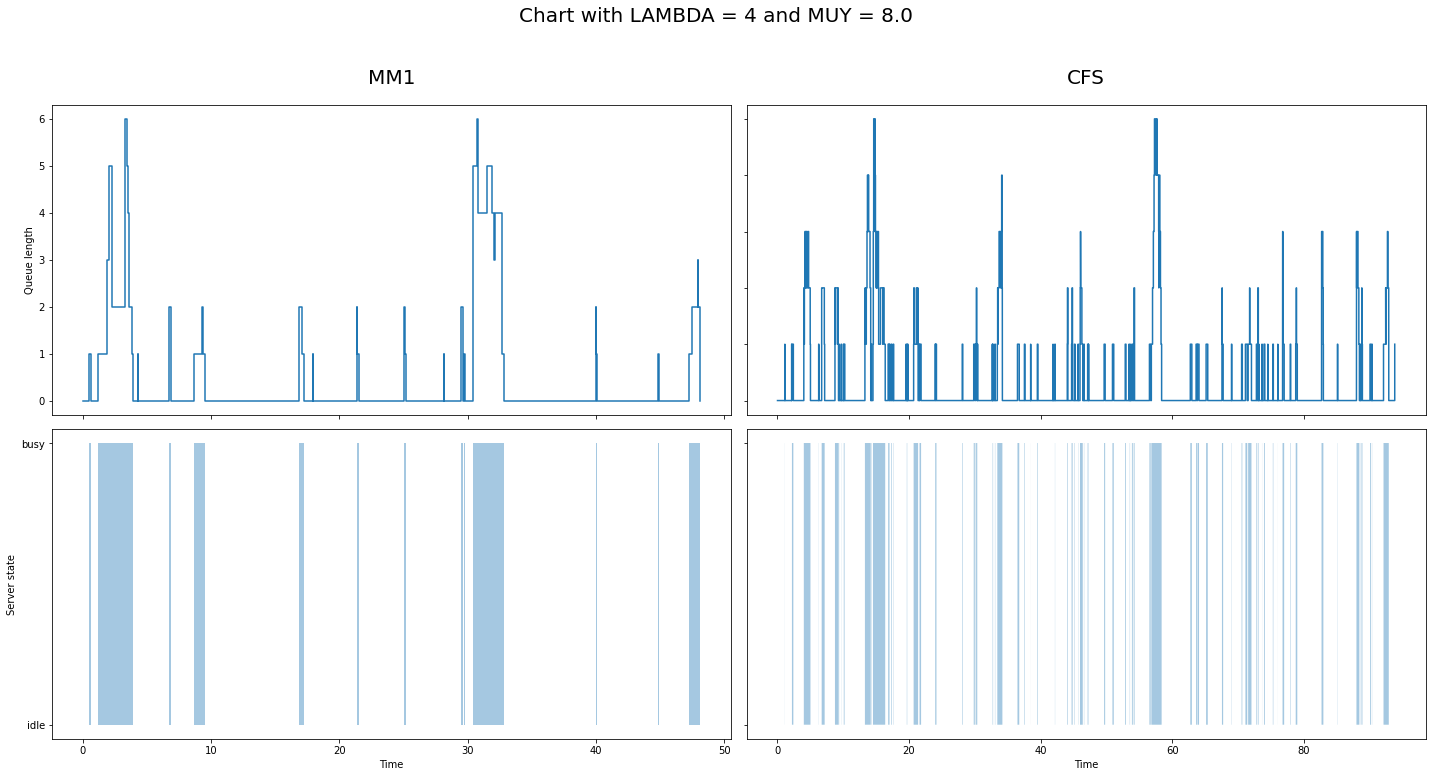

In [ ]:
if LOGGED and PLOTTED and COMPARE_ONE:
    import matplotlib.pyplot as plt
    import statistics
    fig, axs = plt.subplots(2,2, figsize=(20,10))
    fig.suptitle(f'Chart with LAMBDA = {LAMBDA} and MUY = {MU}', y=1.075, fontsize=20)

    mm1_log = np.loadtxt(DATA_PATH + 'mm1-l%d-m%d.csv' % (LAMBDA, MU), delimiter='\t')

    axs[0,0].set(xlabel='Time', ylabel='Queue length')
    axs[0,0].step(mm1_log[:200, 0], mm1_log[:200, 2], where='post')
    axs[0,0].set_title('MM1', y = 1.05, fontsize=20)

    axs[1,0].set(xlabel='Time', ylabel='Server state')
    axs[1,0].set_yticks([0, 1])
    axs[1,0].set_yticklabels(['idle', 'busy'])
    axs[1,0].fill_between(mm1_log[:200, 0], 0, mm1_log[:200, 1], step="post", alpha=.4)


    
    cfs_log = np.loadtxt(DATA_PATH + 'cfs-l%d-m%d.csv' % (LAMBDA, MU), delimiter='\t')

    axs[0,1].set(xlabel='Time', ylabel='Queue length')
    axs[0,1].step(cfs_log[:1500, 0], cfs_log[:1500, 2], where='post')
    axs[0,1].set_title('CFS', y = 1.05, fontsize=20)

    axs[1,1].set(xlabel='Time', ylabel='Server state')
    axs[1,1].set_yticks([0, 1])
    axs[1,1].set_yticklabels(['idle', 'busy'])
    axs[1,1].fill_between(cfs_log[:1500, 0], 0, cfs_log[:1500, 1], step="post", alpha=.4)

    for ax in axs.flat:
      ax.label_outer()
    plt.tight_layout()
    plt.show()


## So sánh 2 Queue theo sự thay đổi của Lambda

In [ ]:
if COMPARE_ALONG:
  df = pd.DataFrame([], columns=['Ultilization','Queue','Waiting Time', 'Response Time', 'Var Waiting Time', 'Var Response Time', 'Jobs', 'Jobs in Queue', 'Waiting for First Serve', '%Job Done', 'Jobs Remain'])
  MAXSIMTIME = 25000
  LOGGED = False
  DELTA = 0.5
  for i in range(1, int((MU - LAMBDA)/DELTA)):
    lamda = np.round(LAMBDA + DELTA*i, 2)
    env = simpy.Environment()
    MyServer = MM1Server( env, SERVICE_DISCIPLINE )
    MyJobGenerator = MM1JobGenerator( env, MyServer, POPULATION, lamda, MU )
    env.run( until = MAXSIMTIME )
    df2 = {'Ultilization': str(lamda) + '/' + str(MU),   
           'Queue': 'MM1', 'Waiting Time': MyServer.waitingTime / MyServer.jobsDone, 
           'Response Time': MyServer.responseTime/MyServer.jobsDone, 
           'Var Waiting Time' : MyServer.squareWaitingTime/MyServer.jobsDone - (MyServer.waitingTime/MyServer.jobsDone)**2,
           'Var Response Time' : MyServer.squareResponseTime/MyServer.jobsDone - (MyServer.responseTime/MyServer.jobsDone)**2,
           'Jobs': MyServer.numOfJobInSys / MAXSIMTIME, 
           'Jobs in Queue': MyServer.numOfJobInQ / MAXSIMTIME, 
           'Waiting for First Serve': MyServer.waitingTime / MyServer.jobsDone, 
           '%Job Done': MyServer.jobsDone / (len(MyServer.Jobs) + MyServer.jobsDone), 
           'Jobs Remain': len(MyServer.Jobs)}
    df = df.append(df2, ignore_index = True)

    env = simpy.Environment() 
    MyServer = CFSServer( env, SERVICE_DISCIPLINE )
    MyJobGenerator = CFSJobGenerator( env, MyServer, POPULATION, lamda, MU )
    env.run( until = MAXSIMTIME )
    df2 = {'Ultilization': str(lamda) + '/' + str(MU),   
           'Queue': 'CFS', 'Waiting Time': MyServer.waitingTime / MyServer.jobsDone, 
           'Response Time': MyServer.responseTime/MyServer.jobsDone, 
           'Var Waiting Time' : MyServer.squareWaitingTime/MyServer.jobsDone - (MyServer.waitingTime/MyServer.jobsDone)**2,
           'Var Response Time' : MyServer.squareResponseTime/MyServer.jobsDone - (MyServer.responseTime/MyServer.jobsDone)**2,
           'Jobs': MyServer.numOfJobInSys / MAXSIMTIME, 
           'Jobs in Queue': MyServer.numOfJobInQ / MAXSIMTIME, 
           'Waiting for First Serve': MyServer.fisrtService / MyServer.jobsDone, 
           '%Job Done': MyServer.jobsDone / (len(MyServer.Jobs) + MyServer.jobsDone), 
           'Jobs Remain': len(MyServer.Jobs)}
    df = df.append(df2, ignore_index = True)
    print(f'Complete loop {i} with lamda = {lamda}, mu = {MU}')
  df.groupby("Ultilization", group_keys=True).apply(lambda x: x)

Complete loop 1 with lamda = 4.5, mu = 8.0
Complete loop 2 with lamda = 5.0, mu = 8.0
Complete loop 3 with lamda = 5.5, mu = 8.0
Complete loop 4 with lamda = 6.0, mu = 8.0
Complete loop 5 with lamda = 6.5, mu = 8.0
Complete loop 6 with lamda = 7.0, mu = 8.0
Complete loop 7 with lamda = 7.5, mu = 8.0


### Đánh giá nhận xét 2

Nhìn vào bảng kết quả và các biểu đồ bên dưới, ta có 1 vài nhận xét sau:

* Khi lamda càng tăng lên thì giá trị các thông số đánh giá hiệu năng đều tăng theo

* Với kết quả mô phỏng bên dưới, khi với các giá trị Lambda khác nhau, Queue sử dụng giải thuật FIFO và CFS có các thông số Waiting Time, Response time gần như bằng nhau. Tuy nhiên, trong quá trình thực hiện chạy thử nhiều lần, nhóm nhận thấy hai đại lượng này giữa 2 giải thuật thường sẽ gần nhau ở các giá trị lambda nhỏ. Khi giá trị Lambda tiến gần tới muy, đôi khi sẽ xảy ra sự chênh lệch hai đại lượng hiệu năng đối với FIFO và CFS (có lúc CFS tốt hơn, nhưng cũng có lúc FIFO tốt hơn).

* Đặc biệt, ở các giá trị lambda khác nhau, dù FIFO và CFS có chung giá trị trung bình của Waiting time và Response time, tuy nhiên phương sai của 2 hai đại lượng này đối với CFS lại lớn hơn nhiều so với FIFO, thể hiện sự phân tán dữ liệu nhiều hơn và 2 đại lượng này dao động bất ổn định hơn so với FIFO.

* Số lượng job trung bình trong hệ thống và số lượng job trung bình trong Queue có xu hướng tăng khi lambda tiến gần muy. Với mỗi giá trị lambda, hai đại lượng này có giá trị gần bằng nhau đối với FIFO và CFS.

*  Về đại lượng Waiting for First Serve, ta có thể thấy rằng với giải thuật CFS giá trị này luôn nhỏ hơn rất nhiều so với giải thuật FIFO vì sự đặc thù của giải thuật CFS, giải thuật này luôn đảm bảo sự công bằng về thời gian phục vụ cho các jobs nên các jobs sẽ không phải đợi quá lâu để được phục vụ, ngược lại với FIFO đôi lúc các jobs sẽ phải chờ 1 khoảng thời gian khá lâu nếu job hiện tại đang được phục vụ có duration time khá lớn

* Do Lambda vẫn bé hơn Muy trong bảng so sánh, tỉ lệ hoàn thành job của 2 loại Queue đều gần đạt ngưỡng 100%.

In [ ]:
df

,Ultilization,Queue,Waiting Time,Response Time,Var Waiting Time,Var Response Time,Jobs,Jobs in Queue,Waiting for First Serve,%Job Done,Jobs Remain
0,4.5/8.0,MM1,0.165127,0.290331,0.068412,0.084309,1.310159,0.745159,0.165127,1.000000,0
1,4.5/8.0,CFS,0.155876,0.280527,0.159896,0.230770,1.261364,0.700879,0.003710,1.000000,0
2,5.0/8.0,MM1,0.209886,0.334867,0.095163,0.110835,1.671819,1.047853,0.209886,1.000000,0
3,5.0/8.0,CFS,0.213010,0.338235,0.318915,0.414209,1.696100,1.068152,0.003792,1.000000,0
4,5.5/8.0,MM1,0.276229,0.401606,0.143366,0.158660,2.212505,1.521794,0.276229,0.999949,7
5,5.5/8.0,CFS,0.270648,0.395512,0.598486,0.720280,2.179455,1.491524,0.003838,0.999920,11
6,6.0/8.0,MM1,0.404065,0.529585,0.289019,0.305714,3.180582,2.426735,0.404065,0.999947,8
7,6.0/8.0,CFS,0.382287,0.507596,1.326170,1.501749,3.045891,2.293958,0.003709,0.999987,2
8,6.5/8.0,MM1,0.562757,0.688198,0.443174,0.459232,4.477123,3.661050,0.562757,0.999982,3
9,6.5/8.0,CFS,0.562141,0.687607,3.384917,3.652450,4.481097,3.663446,0.003468,0.999951,8


In [ ]:
LOGGED = True

In [ ]:
if LOGGED:
  df.to_csv(DATA_PATH + 'compare.csv', index=False)

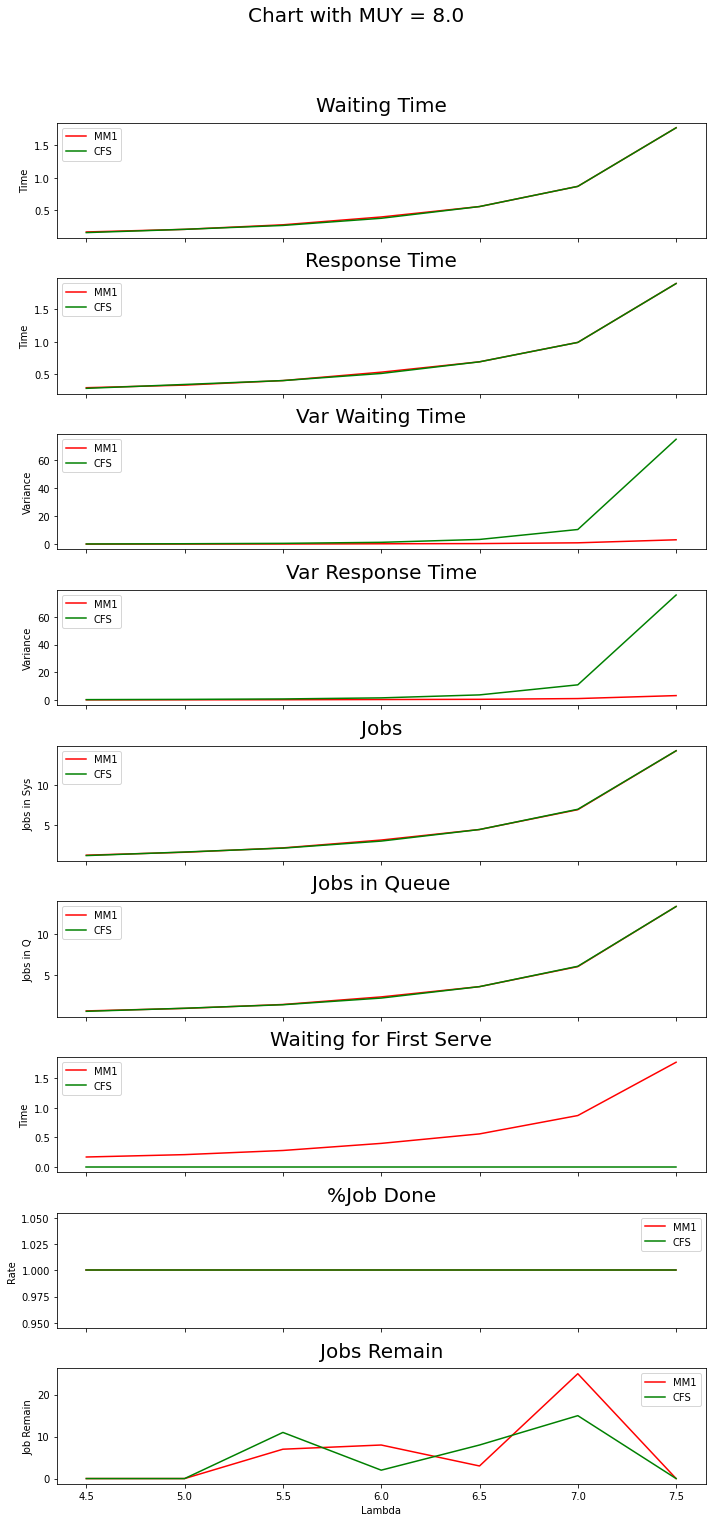

In [ ]:
if COMPARE_ALONG:
  df = pd.read_csv(DATA_PATH + 'compare.csv')
  columns = ['Waiting Time', 'Response Time', 'Var Waiting Time', 'Var Response Time', 'Jobs', 'Jobs in Queue', 'Waiting for First Serve', '%Job Done', 'Jobs Remain']
  y_labels = ['Time', 'Time', 'Variance', "Variance", 'Jobs in Sys', 'Jobs in Q', 'Time', 'Rate', 'Job Remain']


  MM1_df = np.around(df.loc[df['Queue'] == 'MM1'], decimals=2)  
  CFS_df = np.around(df.loc[df['Queue'] == 'CFS'], decimals=2)  
  lamda_value = np.around([float(x.split('/')[0]) for x in MM1_df['Ultilization']], decimals=2)
  

  fig, axs = plt.subplots(len(columns), figsize=(10,20))
  fig.suptitle(f'Chart with MUY = {MU}', y=1.055, fontsize=20)
  
  for col_name, y_label, idx in zip(columns, y_labels, np.arange(len(columns))):
    axs[idx].set(xlabel='Lambda', ylabel=y_label)
    axs[idx].plot(lamda_value, MM1_df[col_name], 'r', label='MM1')
    axs[idx].plot(lamda_value, CFS_df[col_name], 'g', label='CFS')
    axs[idx].set_title(col_name, y = 1.05, fontsize=20)
    axs[idx].legend(['MM1','CFS'])
    # axs[idx,1].set(xlabel='Lambda', ylabel=y_label)
    # axs[idx,1].plot(lamda_value, CFS_df[col_name])
    # axs[idx,1].set_title(col_name, y = 1.05, fontsize=20)
  for ax in axs.flat:
    ax.label_outer()
  plt.tight_layout()

# Tổng kết

Sau khi thực hiện mô phỏng và đưa ra nhũng đánh giá, ta thấy được những khác biệt rõ rệt về 2 loại giải thuật hàng đợi, Completely Fair Scheduling và First In First Out Scheduling, nhìn 1 cách khái quát hơn thì đây còn là 2 đại diện cho 2 loại giải thuật định thời phổ biến hiện nay là Non-Preemptive và Preemtive Scheduling.

Với giải thuật định thời FIFO, ý tưởng hiện thực dễ dàng, các job chỉ ra vào queue 1 lần, các quá trình phục vụ job chỉ ngắt khi hết thời gian phục vụ của job đó, thời gian từ lúc jobs vào queue đến khi được phục vụ tương đối cao hơn so với CFS

Với giải thuật định thời CFS, hiện thực tương đối phức tạp, các job có thể ra vào queue nhiều lần, các quá trình phục vụ job chỉ ngắt khi job hoàn thành hoặc hết thời gian phục vụ được cấp phép cho mỗi job, thời gian từ lúc jobs vào queue đên khi được phục vụ thấp hơn so với giải thuật FIFO